In [ ]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import librosa
import librosa.display

from tqdm.auto import tqdm

import keras
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from keras.layers import Dropout, BatchNormalization, Activation
from keras.models import Sequential
from keras import regularizers

from sklearn.model_selection import train_test_split, StratifiedKFold

import warnings
warnings.filterwarnings(action='ignore') 

In [ ]:
CFG = {
    'SR':16000,
    'N_MFCC':39, # MFCC 벡터를 추출할 개수
    'SEED':1209
}

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(CFG['SEED']) # Seed 고정

In [ ]:
train_x = np.load('/content/drive/MyDrive/dacon_covid/train_mfcc2d/train_x.npy')
train_y = np.load('/content/drive/MyDrive/dacon_covid/train_mfcc2d/train_y.npy')
augmented_train_x = np.load('/content/drive/MyDrive/dacon_covid/augmented_train_mfcc2d/augmented_train_x.npy')
augmented_train_y = np.load('/content/drive/MyDrive/dacon_covid/augmented_train_mfcc2d/augmented_train_y.npy')

test_x = np.load('/content/drive/MyDrive/dacon_covid/test_mfcc2d/test_x.npy')

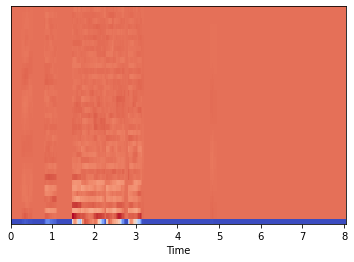

In [ ]:
librosa.display.specshow(train_x[7], sr=16000, x_axis='time')

In [ ]:
train_x = np.concatenate((train_x, augmented_train_x), axis=0)
train_y = np.concatenate((train_y, augmented_train_y), axis=0)

train_x = train_x.reshape(train_x.shape[0], -1, 39, 1)
test_x = test_x.reshape(test_x.shape[0], -1, 39, 1)

# Modeling

In [ ]:
# 하이퍼파라미터
input_shape = (251, 39, 1)
max_epoch = 150
batch_size = 128

In [ ]:
model = Sequential()

# 1
model.add(Conv2D(filters=64,kernel_size=(2,2),input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=32,kernel_size=(2,2)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dropout(0.3))

model.add(Dense(16,activation='relu'))
model.add(Dense(8,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 250, 38, 64)       320       
                                                                 
 batch_normalization (BatchN  (None, 250, 38, 64)      256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 250, 38, 64)       0         
                                                                 
 dropout (Dropout)           (None, 250, 38, 64)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 125, 19, 64)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 18, 32)       8

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1209)

for train_idx, val_idx in kfold.split(train_x, train_y):
    model.fit(train_x[train_idx], train_y[train_idx], 
              epochs=max_epoch, batch_size=batch_size, verbose=1)
    

    scores = model.evaluate(train_x[val_idx], train_y[val_idx], verbose=1)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

In [ ]:
# Train
model.fit(train_x, train_y, epochs=max_epoch, 
          batch_size=batch_size, verbose=1)

In [ ]:
predict_x = model.predict(test_x)
preds = (predict_x > 0.25).astype("int32") # Threshold ==> 0.25

728


In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/dacon_covid/sample_submission.csv')
submission['covid19'] = preds
submission.to_csv('/content/drive/MyDrive/dacon_covid/submit(augmentation,cnn,0.25).csv', index=False)